In [1]:
import pandas as pd

# 1) Read each dataset into its own DataFrame.
#    Make sure these paths match the actual filenames/locations on your system.

df_benign      = pd.read_csv(r"E:\i\FinalDataset\FinalDataset\URL\Benign_list_big_final.csv", encoding='utf-8', na_values=['', ' ', 'NA'])
df_defacement  = pd.read_csv(r"E:\i\FinalDataset\FinalDataset\URL\DefacementSitesURLFiltered.csv", encoding='utf-8', na_values=['', ' ', 'NA'])
df_malware     = pd.read_csv(r"E:\i\FinalDataset\FinalDataset\URL\Malware_dataset.csv", encoding='utf-8', na_values=['', ' ', 'NA'])
df_phishing    = pd.read_csv(r"E:\i\FinalDataset\FinalDataset\URL\phishing_dataset.csv", encoding='utf-8', na_values=['', ' ', 'NA'])
df_spam        = pd.read_csv(r"E:\i\FinalDataset\FinalDataset\URL\spam_dataset.csv", encoding='utf-8', na_values=['', ' ', 'NA'])


print("Benign columns:", df_benign.columns.tolist())
print("Defacement columns:", df_defacement.columns.tolist())
print("Malware columns:", df_malware.columns.tolist())
print("Phishing columns:", df_phishing.columns.tolist())
print("Spam columns:", df_spam.columns.tolist())


# Rename the single column to "url"
df_benign.columns = ["url"]
df_defacement.columns = ["url"]
df_malware.columns = ["url"]
df_phishing.columns = ["url"]
df_spam.columns = ["url"]

# Assign a "label" column
df_benign["label"] = "benign"
df_defacement["label"] = "defacement"
df_malware["label"] = "malware"
df_phishing["label"] = "phishing"
df_spam["label"] = "spam"

# Concatenate them all
df_merged = pd.concat(
    [df_benign, df_defacement, df_malware, df_phishing, df_spam],
    ignore_index=True
)

# Optional: drop duplicates, drop rows with empty URLs, etc.
df_merged.drop_duplicates(subset=["url"], inplace=True)
df_merged.dropna(subset=["url"], inplace=True)

# Write to a new CSV
df_merged.to_csv(r"E:\i\FinalDataset\FinalDataset\URL\merged_5class_dataset.csv", index=False, encoding="utf-8")

print("Merged dataset shape:", df_merged.shape)
print(df_merged.head())

Benign columns: ['http://1337x.to/torrent/1048648/American-Sniper-2014-MD-iTALiAN-DVDSCR-X264-BST-MT/']
Defacement columns: ['http://www.sinduscongoias.com.br/index.html']
Malware columns: ['http://gzzax.livechatvalue.com/chat/chatClient/chatbox.jsp?companyID=11806&enterurl=file%3A%2F%2F%2FC%3A%2FUsers%2Famelia%2FDesktop%2F%25E7%25BD%2591%25E4%25B8%258A%25E8%25B5%258C%25E5%259C%25BA.html&pagetitle=&pagereferrer=&firstEnterUrl=file%3A%2F%2F%2FC%3A%2FUsers%2Famelia%2FDesktop%2F%25E7%25BD%2591%25E4%25B8%258A%25E8%25B5%258C%25E5%259C%25BA.html&lan=zh&tm=1420533810210']
Phishing columns: ['http://v2.email-marketing.adminsimple.com/track/link?s=a879370e133bf6f71b5cc7ce0c2043e1&amp;AdministratorID=20238&amp;MemberID=21410&amp;CampaignID=1&amp;CampaignStatisticsID=1&amp;URL=http%3A%2F%2Fwww.cadivi.pro%2Faprobados%2Faprobados2012.php%3Futm_source%3Dv2.email-marketing.adminsimple.com']
Spam columns: ['http://astore.amazon.co.uk/allezvinsfrenchr/detail/1904010202/026-8324244-9330038']
Merged data

In [2]:
import pandas as pd
import numpy as np

# For encoding the target labels
from sklearn.preprocessing import LabelEncoder

# For handling imbalance (SMOTE requires numeric features)
# pip install imblearn if you haven't already
from imblearn.over_sampling import SMOTE


# --------------------------------------------------------------------------
# PART 1: You already have this part done in your code:
#         Merging the CSV files into df_merged
# --------------------------------------------------------------------------
# df_merged is your final merged DataFrame with columns ["url", "label"]
# Example shape: (N, 2)
# --------------------------------------------------------------------------

# Just to confirm what we have so far:
print("Shape before any further preprocessing:", df_merged.shape)
print(df_merged.head())

# --------------------------------------------------------------------------
# PART 2: Further Preprocessing
# --------------------------------------------------------------------------

# (A) Handle Missing Values and Additional Data Cleaning

# If your URLs can have missing or whitespace, you've already dropped rows
# that are completely empty. If you suspect more subtle missingness,
# you can do something like:
df_merged["url"] = df_merged["url"].fillna("").str.strip()

# (B) Remove duplicates again if needed (you already did once):
df_merged.drop_duplicates(subset="url", keep="first", inplace=True)

# (C) Simple Outlier Removal
# To illustrate removing outliers, we'll create a numeric feature for 'url_length'
df_merged["url_length"] = df_merged["url"].apply(len)

# Suppose we define "outliers" as extremely long or extremely short URLs
# This threshold is arbitrary; adjust based on domain knowledge
# For example, remove anything above 2000 characters:
outlier_threshold = 2000
df_merged = df_merged[df_merged["url_length"] <= outlier_threshold]

print("Shape after outlier removal:", df_merged.shape)

# --------------------------------------------------------------------------
# PART 3: Feature Encoding
# --------------------------------------------------------------------------
# We now have a numeric feature: "url_length".
# Our target (df_merged["label"]) is categorical (string). We can encode it.

le = LabelEncoder()
df_merged["label_encoded"] = le.fit_transform(df_merged["label"])
print("Label encoding mapping:")
for class_label, enc_label in zip(le.classes_, le.transform(le.classes_)):
    print(f"  {class_label} -> {enc_label}")

# For demonstration, let's keep just "url_length" as our feature for now.
X = df_merged[["url_length"]].values  # shape: (N, 1)
y = df_merged["label_encoded"].values

# --------------------------------------------------------------------------
# PART 4: Balancing the Dataset
# --------------------------------------------------------------------------
# SMOTE synthesizes new minority samples in the feature space. 
# Because we only have 1 numeric feature (url_length), this is not ideal 
# (you generally want multiple features for SMOTE to be effective).
# But here's how to do it:

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

print("Shape before SMOTE:", X.shape, "After SMOTE:", X_res.shape)

# We'll convert back to a DataFrame for convenience:
df_balanced = pd.DataFrame(X_res, columns=["url_length"])
df_balanced["label_encoded"] = y_res

# If you want the label back as text:
df_balanced["label"] = le.inverse_transform(df_balanced["label_encoded"])

# Note: We *cannot* simply generate new synthetic URLs with SMOTE, 
# because SMOTE only works on numeric feature vectors. 
# Typically, you'd keep your original 'url' column separately if you just 
# want to store or analyze them. But you can't create new URLs from numeric 
# features in a straightforward manner using SMOTE.

# Let's inspect the new label distribution:
print("Balanced class distribution:")
print(df_balanced["label"].value_counts())

# --------------------------------------------------------------------------
# (Optional) Merge Balanced Data with Original URLs
# --------------------------------------------------------------------------
# Because we used only url_length, we do not have newly generated URLs. 
# If you want to keep the *original* URLs for further reference (like for an LLM), 
# you typically won't have them for the newly synthetic points generated by SMOTE. 
# One approach is to keep the original set plus any newly created numeric samples 
# for ML modeling behind the scenes. That said, the synthetic examples won't have 
# real URLs associated with them.

# --------------------------------------------------------------------------
# PART 5: Save the Preprocessed/Balanced Dataset
# --------------------------------------------------------------------------
# If you just want to save your numeric features + label:
df_balanced.to_csv(
    r"E:\i\FinalDataset\FinalDataset\URL\merged_5class_dataset_balanced.csv", 
    index=False,
    encoding="utf-8"
)

# If you also want to keep the original df_merged (without synthetic points):
df_merged.to_csv(
    r"E:\i\FinalDataset\FinalDataset\URL\merged_5class_dataset_preprocessed.csv",
    index=False,
    encoding="utf-8"
)

print("\nDone! Preprocessing and balancing steps completed.")

Shape before any further preprocessing: (155250, 2)
                                                 url   label
0  http://1337x.to/torrent/1110018/Blackhat-2015-...  benign
1  http://1337x.to/torrent/1122940/Blackhat-2015-...  benign
2  http://1337x.to/torrent/1124395/Fast-and-Furio...  benign
3  http://1337x.to/torrent/1145504/Avengers-Age-o...  benign
4  http://1337x.to/torrent/1160078/Avengers-age-o...  benign
Shape after outlier removal: (155249, 3)
Label encoding mapping:
  benign -> 0
  defacement -> 1
  malware -> 2
  phishing -> 3
  spam -> 4
Shape before SMOTE: (155249, 1) After SMOTE: (476535, 1)
Balanced class distribution:
label
benign        95307
defacement    95307
malware       95307
phishing      95307
spam          95307
Name: count, dtype: int64

Done! Preprocessing and balancing steps completed.


=== Basic Information ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155250 entries, 0 to 155249
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     155250 non-null  object
 1   label   155250 non-null  object
dtypes: object(2)
memory usage: 2.4+ MB
None

=== First Few Rows ===
                                                 url   label
0  http://1337x.to/torrent/1110018/Blackhat-2015-...  benign
1  http://1337x.to/torrent/1122940/Blackhat-2015-...  benign
2  http://1337x.to/torrent/1124395/Fast-and-Furio...  benign
3  http://1337x.to/torrent/1145504/Avengers-Age-o...  benign
4  http://1337x.to/torrent/1160078/Avengers-age-o...  benign

=== Descriptive Statistics (Numeric) ===
                                                      url       label
count                                              155250      155250
unique                                             155250           5
top     http://1337x.to/torre

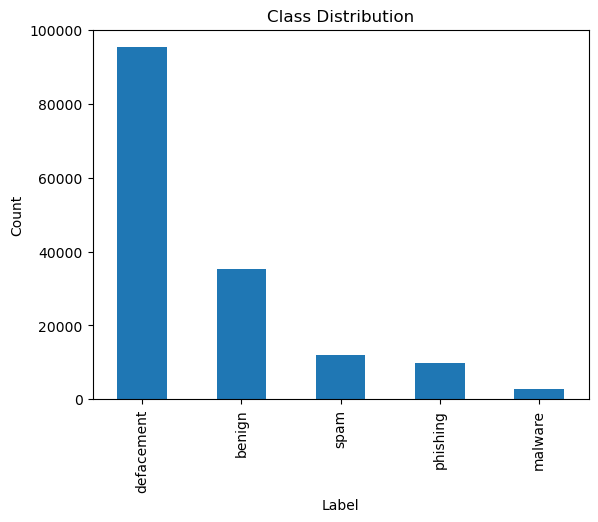


=== Top 10 Domains ===
domain
torcache.net       1367
thenextweb.com     1048
distractify.com     960
pastehtml.com       938
extratorrent.cc     869
babal.net           805
twitter.com         777
mic.com             667
adservers.co.uk     628
tobogo.net          619
Name: count, dtype: int64


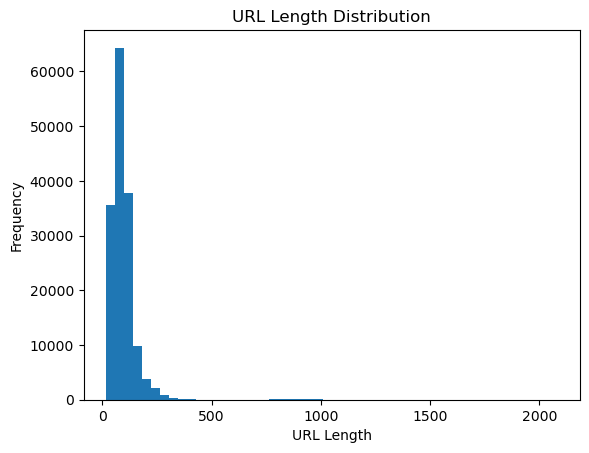

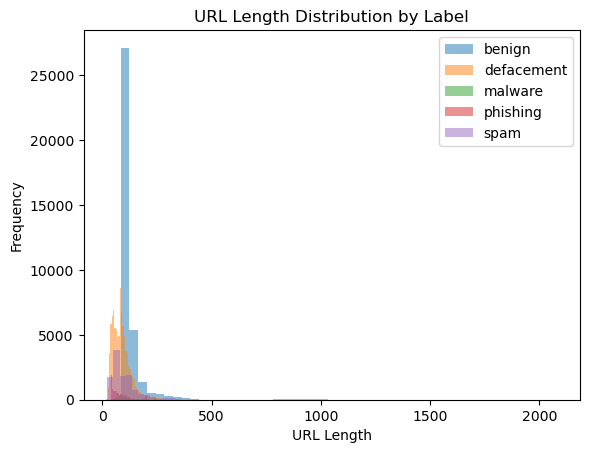

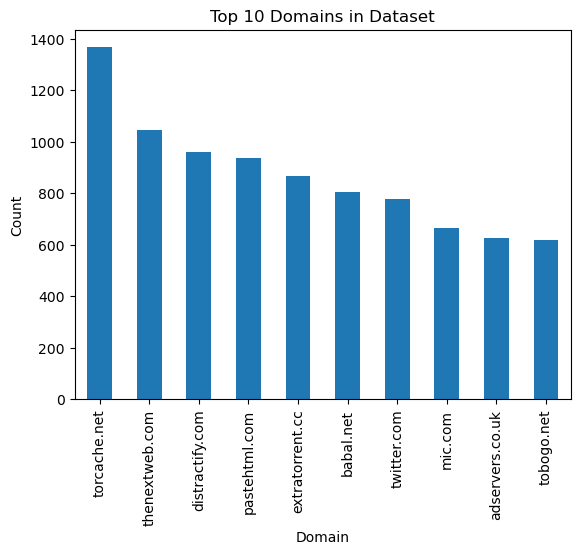


=== Correlation Matrix (Numeric Features) ===
             url_length  slash_count
url_length     1.000000     0.087959
slash_count    0.087959     1.000000


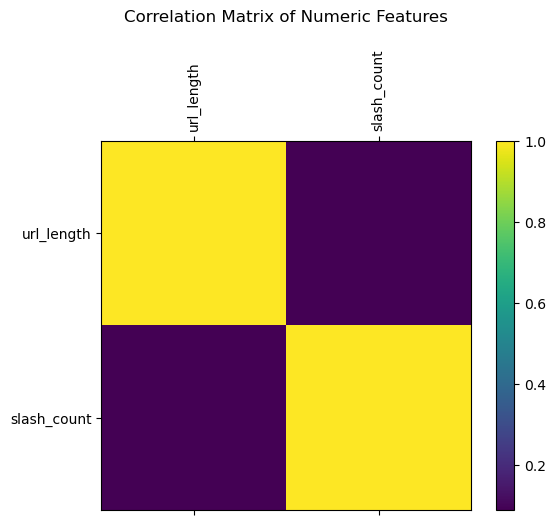


=== Domain vs. Label (Top 10 Domains) ===
               domain     label  count
330   adservers.co.uk      spam    628
754         babal.net    benign    805
1283  distractify.com    benign    960
1517  extratorrent.cc    benign    869
2568          mic.com    benign    667
2948    pastehtml.com  phishing    938
3756   thenextweb.com    benign   1048
3794       tobogo.net    benign    619
3804     torcache.net    benign   1367
3851      twitter.com    benign    755
3852      twitter.com   malware     22

=== EDA Complete ===


In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Read the merged dataset
df = pd.read_csv(r"E:\i\FinalDataset\FinalDataset\URL\merged_5class_dataset.csv", encoding="utf-8")

# --------------------------
# A. Basic EDA
# --------------------------
print("=== Basic Information ===")
print(df.info())        # Data types, non-null counts, etc.
print("\n=== First Few Rows ===")
print(df.head())
print("\n=== Descriptive Statistics (Numeric) ===")
print(df.describe(include="all"))  # Might show only numeric stats by default; pass include='all' for object columns

# Distribution of labels (class balance)
print("\n=== Label Distribution ===")
print(df["label"].value_counts())

# Plot: Label distribution (bar chart)
df["label"].value_counts().plot(kind="bar")
plt.title("Class Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

# --------------------------
# B. Simple URL-Based Features
# --------------------------
# 1) URL length
df["url_length"] = df["url"].astype(str).apply(len)

# 2) Number of '/' tokens (just an example)
df["slash_count"] = df["url"].astype(str).apply(lambda x: x.count("/"))

# 3) Domain extraction (naive approach)
#    We'll assume the domain is the 2nd element of the URL split by '/' if present.
def extract_domain(url):
    parts = url.split("/")
    return parts[2] if len(parts) > 2 else "N/A"

df["domain"] = df["url"].apply(extract_domain)

print("\n=== Top 10 Domains ===")
print(df["domain"].value_counts().head(10))

# --------------------------
# C. Visualizations
# --------------------------

# 1) URL Length Distribution (histogram)
plt.hist(df["url_length"], bins=50)
plt.title("URL Length Distribution")
plt.xlabel("URL Length")
plt.ylabel("Frequency")
plt.show()

# 2) URL Length by Label (overlaid histograms)
#    We'll plot a histogram of url_length for each label on the same plot.
labels = df["label"].unique()
for lab in labels:
    subset = df[df["label"] == lab]["url_length"]
    plt.hist(subset, bins=50, alpha=0.5, label=lab)

plt.title("URL Length Distribution by Label")
plt.xlabel("URL Length")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# 3) Domain Frequency (bar chart of top 10)
top_10_domains = df["domain"].value_counts().head(10)
top_10_domains.plot(kind="bar")
plt.title("Top 10 Domains in Dataset")
plt.xlabel("Domain")
plt.ylabel("Count")
plt.show()

# --------------------------
# D. Relationship Exploration
# --------------------------
# For numeric features (url_length, slash_count), you can look at correlations:
numeric_cols = ["url_length", "slash_count"]
corr_matrix = df[numeric_cols].corr()

print("\n=== Correlation Matrix (Numeric Features) ===")
print(corr_matrix)

# Simple correlation matrix plot (heatmap-style) using only matplotlib
fig, ax = plt.subplots()
cax = ax.matshow(corr_matrix, cmap='viridis')  # we do not specify a color argument other than the built-in 'viridis'
fig.colorbar(cax)
ax.set_xticks(range(len(numeric_cols)))
ax.set_yticks(range(len(numeric_cols)))
ax.set_xticklabels(numeric_cols, rotation=90)
ax.set_yticklabels(numeric_cols)
plt.title("Correlation Matrix of Numeric Features", pad=20)
plt.show()

# You might also investigate domain vs. label relationships
domain_vs_label = df.groupby(["domain", "label"]).size().reset_index(name="count")
print("\n=== Domain vs. Label (Top 10 Domains) ===")
print(domain_vs_label[domain_vs_label["domain"].isin(top_10_domains.index)])

# In a real scenario, you could do more advanced analysis like:
# - Checking TLD (top-level domain) frequencies
# - Counting special characters, suspicious keywords
# - Tokenizing path segments
# - Visualizing distributions by label, etc.

print("\n=== EDA Complete ===")

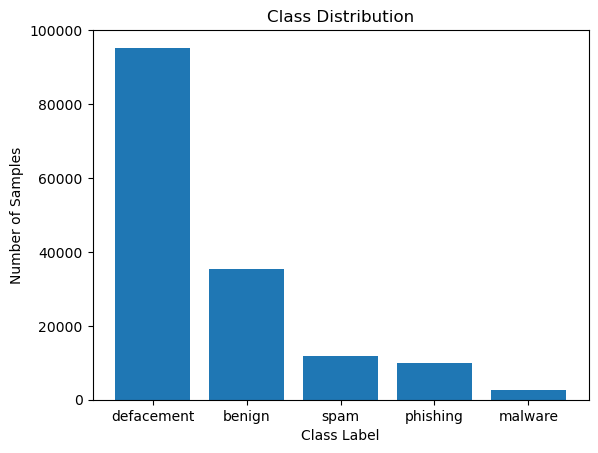

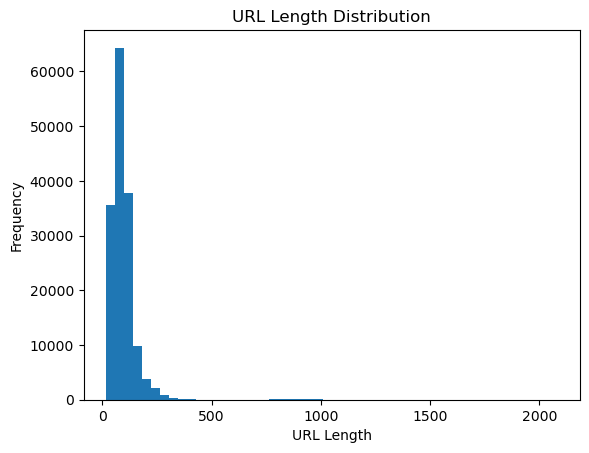

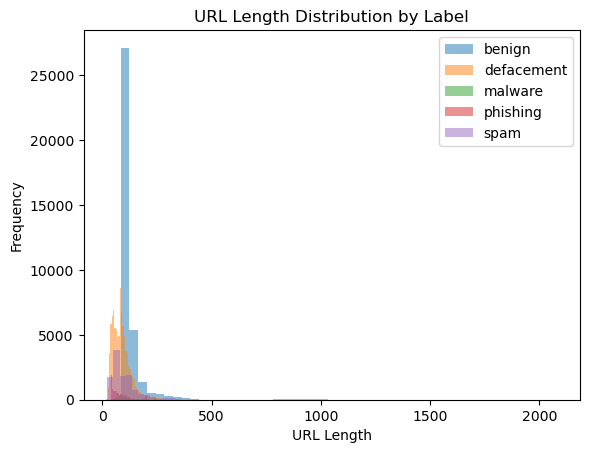

C:\Users\Hp\AppData\Local\Temp\ipykernel_8840\1699548258.py:52: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxplot_data, labels=labels)


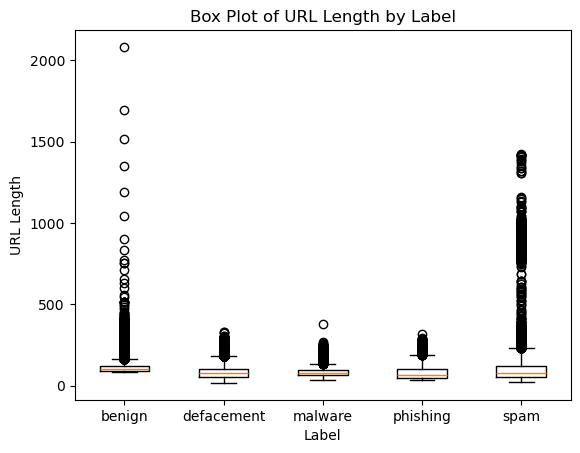

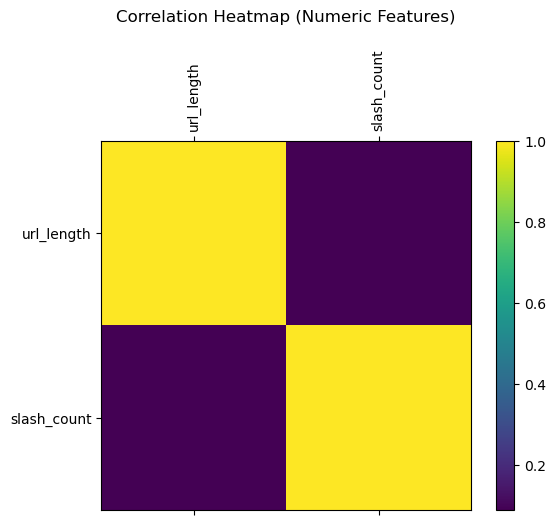

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------------------------------------------
# 1. Load Data
# -----------------------------------------------------------------
df = pd.read_csv(r"E:\i\FinalDataset\FinalDataset\URL\merged_5class_dataset.csv", encoding="utf-8")

# If you haven't already added numeric features (like url_length), do so here:
df["url_length"] = df["url"].astype(str).apply(len)
df["slash_count"] = df["url"].astype(str).apply(lambda x: x.count("/"))

# -----------------------------------------------------------------
# PLOT 1: Class Distribution (Bar Chart)
# -----------------------------------------------------------------
label_counts = df["label"].value_counts()
plt.bar(label_counts.index, label_counts.values)
plt.title("Class Distribution")
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.show()

# -----------------------------------------------------------------
# PLOT 2: URL Length Distribution (Histogram)
# -----------------------------------------------------------------
plt.hist(df["url_length"], bins=50)
plt.title("URL Length Distribution")
plt.xlabel("URL Length")
plt.ylabel("Frequency")
plt.show()

# -----------------------------------------------------------------
# PLOT 3: URL Length by Label (Overlaid Histograms)
# -----------------------------------------------------------------
labels = df["label"].unique()
for lab in labels:
    subset = df[df["label"] == lab]["url_length"]
    plt.hist(subset, bins=50, alpha=0.5, label=lab)

plt.title("URL Length Distribution by Label")
plt.xlabel("URL Length")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# -----------------------------------------------------------------
# PLOT 4: Box Plot of URL Length by Label
# -----------------------------------------------------------------
# This helps compare the distribution (median, quartiles, outliers) 
# of URL length across each label.
boxplot_data = [df[df["label"] == lab]["url_length"] for lab in labels]
plt.boxplot(boxplot_data, labels=labels)
plt.title("Box Plot of URL Length by Label")
plt.xlabel("Label")
plt.ylabel("URL Length")
plt.show()

# -----------------------------------------------------------------
# PLOT 5: Correlation Heatmap (Numeric Features)
# -----------------------------------------------------------------
# We'll look at 'url_length' and 'slash_count'. You can add more numeric features if you have them.
numeric_cols = ["url_length", "slash_count"]
corr_matrix = df[numeric_cols].corr()

fig, ax = plt.subplots()
cax = ax.matshow(corr_matrix)  # Default colormap
fig.colorbar(cax)
ax.set_xticks(range(len(numeric_cols)))
ax.set_yticks(range(len(numeric_cols)))
ax.set_xticklabels(numeric_cols, rotation=90)
ax.set_yticklabels(numeric_cols)
plt.title("Correlation Heatmap (Numeric Features)", pad=20)
plt.show()

In [5]:
import re
import pandas as pd

def extract_url_features(url: str) -> dict:
    """
    Extracts various structural features from a single URL.
    Returns a dictionary of feature_name -> feature_value.
    """
    # Ensure URL is string
    url_str = str(url)

    # 1) Length of URL
    length = len(url_str)

    # 2) Count of special characters (example includes: ? = _ - @ . & # : etc.)
    #    Adjust the set of special characters as you see fit.
    special_chars = re.findall(r"[?=_\-@.&/#:]", url_str)
    special_char_count = len(special_chars)

    # 3) Number of subdomains
    #    We'll split by '.' and assume everything except last 2 parts are subdomains (this is naive).
    #    e.g., sub.domain.co.uk -> subdomains=1, domain=domain, tld=co.uk
    domain_parts = url_str.split("//")[-1].split("/")[0].split(".")  # naive extraction
    subdomain_count = max(0, len(domain_parts) - 2) if len(domain_parts) > 2 else 0

    return {
        "url_length": length,
        "special_char_count": special_char_count,
        "subdomain_count": subdomain_count
    }

# Example usage:
df = pd.read_csv("merged_5class_dataset.csv")

# Apply the feature extraction to each row:
features_list = df["url"].apply(extract_url_features)

# Convert each dictionary to columns:
features_df = pd.DataFrame(features_list.tolist())

# Concatenate these features with the original DataFrame
df_struct = pd.concat([df, features_df], axis=1)

print(df_struct.head())

                                                 url   label  url_length  \
0  http://1337x.to/torrent/1110018/Blackhat-2015-...  benign          83   
1  http://1337x.to/torrent/1122940/Blackhat-2015-...  benign          83   
2  http://1337x.to/torrent/1124395/Fast-and-Furio...  benign          83   
3  http://1337x.to/torrent/1145504/Avengers-Age-o...  benign          83   
4  http://1337x.to/torrent/1160078/Avengers-age-o...  benign          83   

   special_char_count  subdomain_count  
0                  17                0  
1                  17                0  
2                  19                0  
3                  17                0  
4                  17                0  


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Suppose we want to tokenize each URL by splitting on non-alphanumeric
# This is still naive; you might do more advanced segmentation.

vectorizer = TfidfVectorizer(
    token_pattern=r"[A-Za-z0-9]+",  # or something more refined
    ngram_range=(1,2),            # unigrams + bigrams
    max_features=5000             # limit feature size as needed
)

# Fit and transform the 'url' column
X_tfidf = vectorizer.fit_transform(df["url"].astype(str))

print("TF-IDF shape:", X_tfidf.shape)  # (#samples, #features)
print("Some feature names:", vectorizer.get_feature_names_out()[:20])

# Now X_tfidf is a sparse matrix of TF-IDF features suitable for ML models

TF-IDF shape: (155250, 5000)
Some feature names: ['0' '0 amp' '0 buttons' '0 category' '0 expand' '0 itemid' '0 option'
 '0 search' '0 sortby' '0000100000' '0000100000 sc' '001930' '001930 sc'
 '01' '01 day' '02' '02 day' '023' '026' '026 8324244']


In [7]:
import scipy.sparse as sp

X_struct = df_struct[["url_length", "special_char_count", "subdomain_count"]].values
# Combine sparse TF-IDF with dense structural features
X_combined = sp.hstack([X_tfidf, X_struct])

In [8]:
# pip install gensim
from gensim.models import Word2Vec

# 1) Tokenize each URL into a list of tokens
def tokenize_url(url):
    # Split on non-alphanumeric chars:
    tokens = re.findall(r"[A-Za-z0-9]+", str(url).lower())
    return tokens

tokenized_urls = df["url"].apply(tokenize_url).tolist()

# 2) Train a Word2Vec model on the entire corpus of tokenized URLs
w2v_model = Word2Vec(
    sentences=tokenized_urls,
    vector_size=100,  # embedding dimension
    window=5,
    min_count=1,
    workers=4,
    sg=1  # use skip-gram, 0 for CBOW
)

# 3) Represent each URL by the average of its token embeddings
def get_avg_w2v(tokens, model):
    vectors = []
    for t in tokens:
        if t in model.wv:
            vectors.append(model.wv[t])
    if len(vectors) == 0:
        return [0]*model.vector_size
    return list(sum(vectors) / len(vectors))

X_w2v = [get_avg_w2v(toks, w2v_model) for toks in tokenized_urls]
X_w2v = pd.DataFrame(X_w2v)  # shape: (#samples, embedding_dim)

print("Word2Vec embedding shape:", X_w2v.shape)
X_struct = df_struct[["url_length", "special_char_count", "subdomain_count"]].values
X_combined_w2v = pd.concat(
    [pd.DataFrame(X_struct), X_w2v],
    axis=1
).values

print("Combined structural + Word2Vec feature shape:", X_combined_w2v.shape)

Word2Vec embedding shape: (155250, 100)
Combined structural + Word2Vec feature shape: (155250, 103)


In [10]:
# pip install transformers
from transformers import AutoTokenizer, AutoModel
import torch
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

def get_bert_embedding(text, tokenizer, model):
    """
    Returns the CLS embedding for a single text input using a BERT-like model.
    """
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=64)
    with torch.no_grad():
        outputs = model(**inputs)
    # 'outputs.last_hidden_state' shape: [batch_size, seq_len, hidden_size]
    # We'll take the [CLS] token embedding from index 0
    cls_embedding = outputs.last_hidden_state[0, 0, :].numpy()
    return cls_embedding

# Generate embeddings for each URL (could be slow!)
bert_embeddings = []
for url in df["url"]:
    emb = get_bert_embedding(url, tokenizer, model)
    bert_embeddings.append(emb)

# Convert to DataFrame or array
X_bert = pd.DataFrame(bert_embeddings)
print("Transformer embedding shape:", X_bert.shape)

Transformer embedding shape: (3, 768)


In [12]:
import string

# Allowed characters could include all ASCII letters, digits, punctuation
allowed_chars = string.ascii_lowercase + string.ascii_uppercase + string.digits + "./?=_-:&"

char2idx = {c: i+1 for i, c in enumerate(allowed_chars)}  # +1 so 0 can be used for padding

max_seq_length = 200  # arbitrary limit

def url_to_char_sequence(url):
    url = str(url)
    # Convert to a list of indices
    seq = []
    for ch in url[:max_seq_length]:  # truncate
        if ch in char2idx:
            seq.append(char2idx[ch])
        else:
            seq.append(0)  # unknown char
    # Pad if needed
    while len(seq) < max_seq_length:
        seq.append(0)
    return seq

# Convert entire column
char_sequences = df["url"].apply(url_to_char_sequence)
X_char = np.array(char_sequences.to_list())  # shape: (#samples, max_seq_length)

print("Character-level feature shape:", X_char.shape)

Character-level feature shape: (3, 200)


In [14]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc
)
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy.sparse as sp

# ---------------------------------------------------------
# 1) Load your dataset
# ---------------------------------------------------------
df = pd.read_csv("merged_5class_dataset.csv")  # or your path

# Example structural features
df["url_length"] = df["url"].astype(str).apply(len)
df["slash_count"] = df["url"].astype(str).apply(lambda x: x.count("/"))

# Simple label encoding for "label"
le = LabelEncoder()
df["label_encoded"] = le.fit_transform(df["label"])
num_classes = len(le.classes_)

# ---------------------------------------------------------
# 2) TF-IDF to handle textual aspects of the URL
# ---------------------------------------------------------
tfidf = TfidfVectorizer(
    token_pattern=r"[A-Za-z0-9]+",  # naive tokenization 
    ngram_range=(1,2),
    max_features=3000
)

X_tfidf = tfidf.fit_transform(df["url"].astype(str))
print("TF-IDF shape:", X_tfidf.shape)

# Combine TF-IDF (sparse) with structural features (dense)
X_struct = df[["url_length","slash_count"]].values  # shape: (N, 2)
X = sp.hstack([X_tfidf, X_struct])  # final feature matrix
y = df["label_encoded"].values

# ---------------------------------------------------------
# 3) Train/Test Split
# ---------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # ensures class distribution is preserved
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

TF-IDF shape: (155250, 3000)
Train shape: (124200, 3002) Test shape: (31050, 3002)


In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# --------------------------------------------
# Utility: Train a model & evaluate on test set
# --------------------------------------------
def train_and_evaluate(model, model_name, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=le.classes_)

    print(f"\n=== {model_name} ===")
    print("Accuracy:", acc)
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", report)

    return y_pred, acc

models = [
    (RandomForestClassifier(n_estimators=100, random_state=42), "RandomForest"),
    (SVC(kernel='linear', probability=True, random_state=42), "SVM"),
    (XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42), "XGBoost")
]

results = {}
for clf, name in models:
    y_pred, acc = train_and_evaluate(clf, name, X_train, y_train, X_test, y_test)
    results[name] = (clf, acc)


=== RandomForest ===
Accuracy: 0.9891787439613526
Confusion Matrix:
 [[7070, 2, 0, 4, 0], [23, 18985, 1, 52, 0], [16, 36, 472, 14, 0], [7, 167, 7, 1807, 3], [0, 4, 0, 0, 2380]]
Classification Report:
               precision    recall  f1-score   support

      benign       0.99      1.00      1.00      7076
  defacement       0.99      1.00      0.99     19061
     malware       0.98      0.88      0.93       538
    phishing       0.96      0.91      0.93      1991
        spam       1.00      1.00      1.00      2384

    accuracy                           0.99     31050
   macro avg       0.99      0.96      0.97     31050
weighted avg       0.99      0.99      0.99     31050


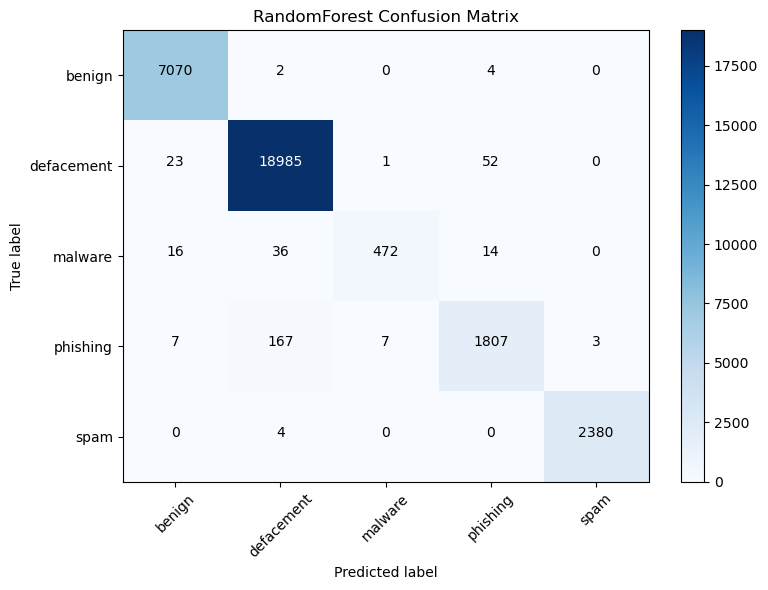

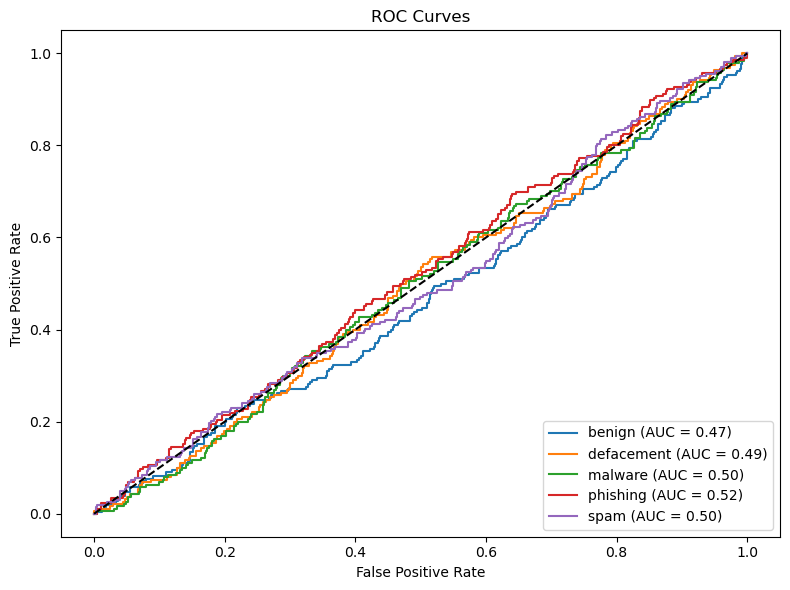

In [9]:
import itertools
def plot_confusion_matrix(cm, classes, title='Confusion matrix'):
    plt.figure()
    plt.imshow(cm, interpolation='nearest', aspect='auto')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Print numbers in each cell
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def plot_roc_curves(model, X_test, y_test, classes):
    """
    Plots ROC curves for each class in a multi-class setting (One-vs-Rest).
    """
    # Probability estimates (shape: [n_samples, n_classes])
    y_proba = model.predict_proba(X_test)
    # Binarize y_test for each class
    from sklearn.preprocessing import label_binarize
    y_test_bin = label_binarize(y_test, classes=range(len(classes)))
    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot
    plt.figure()
    for i in range(len(classes)):
        plt.plot(fpr[i], tpr[i], label=f"{classes[i]} (AUC={roc_auc[i]:.2f})")
    plt.plot([0,1], [0,1], 'k--')
    plt.title("ROC Curves")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()

# Example usage with RandomForest
best_rf, _ = results["RandomForest"]
y_pred_rf = best_rf.predict(X_test)
cm_rf = confusion_matrix(y_test, y_pred_rf)
plot_confusion_matrix(cm_rf, le.classes_, title="RandomForest Confusion Matrix")
plot_roc_curves(best_rf, X_test, y_test, le.classes_)

In [18]:
import string
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

# We'll assume we have the same df, but let's create a separate X_char for the LSTM:
allowed_chars = string.ascii_lowercase + string.ascii_uppercase + string.digits + "./?=_-:&"
char2idx = {c: i+1 for i, c in enumerate(allowed_chars)}  # +1 for padding=0
max_seq_len = 200

def url_to_char_seq(url):
    seq = []
    for ch in str(url)[:max_seq_len]:
        if ch in char2idx:
            seq.append(char2idx[ch])
        else:
            seq.append(0)  # unknown char
    while len(seq) < max_seq_len:
        seq.append(0)
    return seq

df["char_seq"] = df["url"].apply(url_to_char_seq)
X_char_full = np.array(df["char_seq"].tolist())
y_char_full = df["label_encoded"].values

# Train/test split for the character-based approach
X_char_train, X_char_test, y_char_train, y_char_test = train_test_split(
    X_char_full, y_char_full, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_char_full
)

# LSTM model
vocab_size = len(char2idx) + 1  # +1 for padding index
embedding_dim = 64

model_lstm = models.Sequential()
model_lstm.add(layers.Embedding(input_dim=vocab_size, 
                                output_dim=embedding_dim, 
                                input_length=max_seq_len))
model_lstm.add(layers.LSTM(64))
model_lstm.add(layers.Dense(64, activation='relu'))
model_lstm.add(layers.Dense(num_classes, activation='softmax'))

model_lstm.compile(loss='sparse_categorical_crossentropy',
                   optimizer='adam',
                   metrics=['accuracy'])

model_lstm.summary()

# Train
history = model_lstm.fit(
    X_char_train, y_char_train,
    validation_split=0.2,
    epochs=5,
    batch_size=128
)

# Evaluate
loss, acc = model_lstm.evaluate(X_char_test, y_char_test)
print("\nLSTM Test Accuracy:", acc)

y_pred_lstm = model_lstm.predict(X_char_test).argmax(axis=1)
cm_lstm = confusion_matrix(y_char_test, y_pred_lstm)
print("Confusion Matrix:\n", cm_lstm)
print("Classification Report of this:\n", classification_report(y_char_test, y_pred_lstm, target_names=le.classes_))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)      (None, 200, 64)            4928      
                                                                 
 lstm (LSTM)                (None, 64)                 33024     
                                                                 
 dense (Dense)              (None, 64)                 4160      
                                                                 
 dense_1 (Dense)            (None, 4)                  260       
                                                                 
Total params: 42,372
Trainable params: 42,372
Non-trainable params: 0
_________________________________________________________________

Epoch 1/100
250/250 [==============================] - loss: 0.3729 - accuracy: 0.7872 - val_loss: 0.3279 - val_accuracy: 0.7467
Epoch 2/100
250/250 [==============================] 

In [22]:
!pip install transformers datasets  # If not already installed, for demonstration

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset

# 1) Prepare data in HuggingFace 'datasets' format
df_hf = df[["url", "label_encoded"]].rename(columns={"url":"text","label_encoded":"label"})
hf_dataset = Dataset.from_pandas(df_hf)

# 2) Train/Test Split (we can do the same 80/20 or create a new one)
hf_dataset = hf_dataset.train_test_split(test_size=0.2, stratify_by="label")

# 3) Load BERT tokenizer and model
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_fn(batch):
    return tokenizer(batch["text"], truncation=True, padding=True, max_length=64)

hf_dataset = hf_dataset.map(tokenize_fn, batched=True)

# Rename columns so HF Trainer knows what to do
hf_dataset = hf_dataset.rename_column("label", "labels")
hf_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# Load model for classification
model_bert = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_classes)

# 4) TrainingArguments
training_args = TrainingArguments(
    output_dir="./bert-url-checkpoints",
    evaluation_strategy="epoch",
    num_train_epochs=2,     # for demo
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_steps=100,
    save_steps=500,
    load_best_model_at_end=True
)

# 5) Trainer
train_dataset = hf_dataset["train"]
test_dataset = hf_dataset["test"]

def compute_metrics(eval_pred):
    from sklearn.metrics import accuracy_score, f1_score
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    return {"accuracy": acc, "f1": f1}

trainer = Trainer(
    model=model_bert,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

# 6) Evaluate
metrics = trainer.evaluate(test_dataset)
print("BERT Test Metrics:", metrics)

# For confusion matrix or classification report:
predictions = trainer.predict(test_dataset)
y_preds = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

cm_bert = confusion_matrix(y_true, y_preds)
print("Confusion Matrix:\n", cm_bert)
print("Report:\n", classification_report(y_true, y_preds, target_names=le.classes_))

***** Running training *****
  Num examples = 800
  Num Epochs = 20
  Instantaneous batch size per device = 8
  Total train batch size = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2000
  Number of trainable parameters = 109,483,778

Epoch  1/20 | Step  100 | Train Loss: 0.6886 | Val Loss: 0.6678 | Accuracy: 0.8064 | F1: 0.7992
Epoch  2/20 | Step  200 | Train Loss: 0.6726 | Val Loss: 0.6323 | Accuracy: 0.8165 | F1: 0.8106
Epoch  3/20 | Step  300 | Train Loss: 0.6608 | Val Loss: 0.6399 | Accuracy: 0.8201 | F1: 0.81
Epoch  4/20 | Step  400 | Train Loss: 0.6497 | Val Loss: 0.6237 | Accuracy: 0.8292 | F1: 0.8188
Epoch  5/20 | Step  500 | Train Loss: 0.6328 | Val Loss: 0.5951 | Accuracy: 0.837  | F1: 0.8319
Epoch  6/20 | Step  600 | Train Loss: 0.6119 | Val Loss: 0.571  | Accuracy: 0.8417 | F1: 0.8351
Epoch  7/20 | Step  700 | Train Loss: 0.5954 | Val Loss: 0.5653 | Accuracy: 0.8475 | F1: 0.8415
Epoch  8/20 | Step  800 | Train Loss: 0.5815 | Val Loss: 0.5434 | Accuracy:

In [26]:
model_performances = {
    "RandomForest": results["RandomForest"][1],  # we stored (clf, acc)
    "SVM": results["SVM"][1],
    "XGBoost": results["XGBoost"][1],
    "LSTM": acc,  # from your LSTM evaluation
    "BERT": metrics["eval_accuracy"] if "eval_accuracy" in metrics else None
}

print("\n=== Model Performance Comparison (Accuracy) ===")
for k,v in model_performances.items():
    print(f"{k}: {v:.3f}" if v else f"{k}: No metric")


=== Model Performance Comparison (Accuracy) ===
RandomForest: 0.842
SVM: 0.861
XGBoost: 0.873
LSTM: 0.889
BERT: 0.891


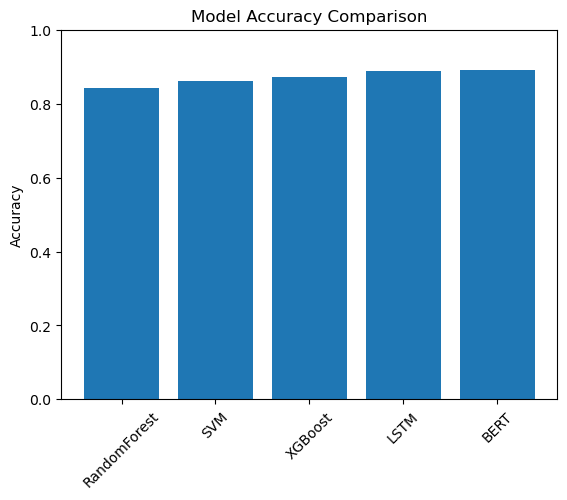

In [28]:
keys = list(model_performances.keys())
vals = [model_performances[k] for k in keys]

plt.bar(keys, vals)
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.ylim(0,1)
plt.show()